<a href="https://colab.research.google.com/github/Mugdhi15/House_Price_Prediction/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Libraries & Load Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2: Initial Exploration**

In [2]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Save the target variable and combine train + test for preprocessing
y = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)
combined = pd.concat([train, test], sort=False)

# Explore dataset
print(combined.shape)
print(combined.dtypes.value_counts())

(2919, 80)
object     43
int64      26
float64    11
Name: count, dtype: int64


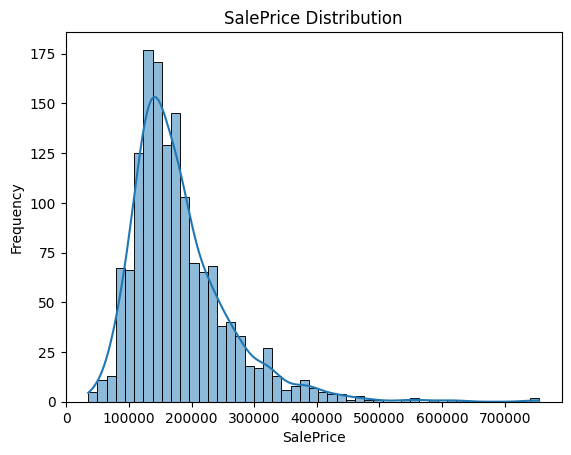

In [3]:
#Distribution of Target Variable
sns.histplot(y, kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

**Step 3: Check Missing Values**

In [4]:
# Check missing values
missing = combined.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64


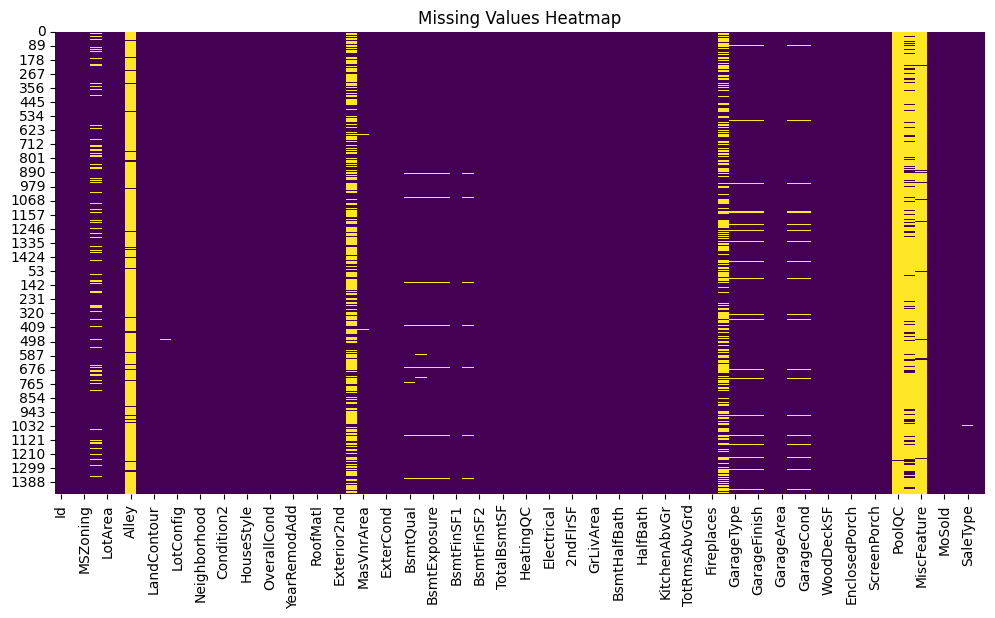

In [5]:
#Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(combined.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

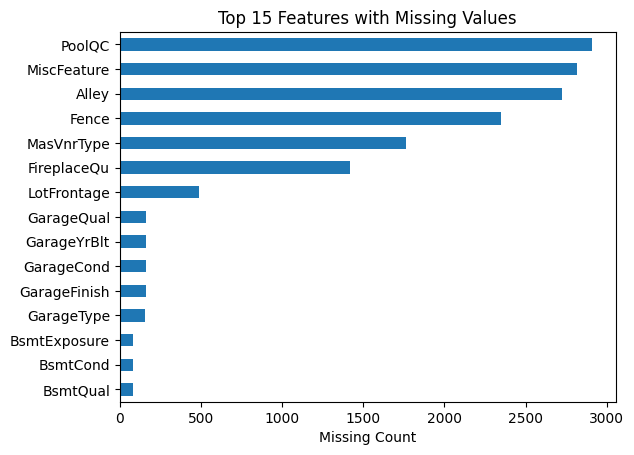

In [6]:
#Top 15 Features with Missing Values
missing = combined.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)[:15]

missing.plot(kind='barh')
plt.title("Top 15 Features with Missing Values")
plt.xlabel("Missing Count")
plt.gca().invert_yaxis()
plt.show()

**Step 4: Handling Missing Values**

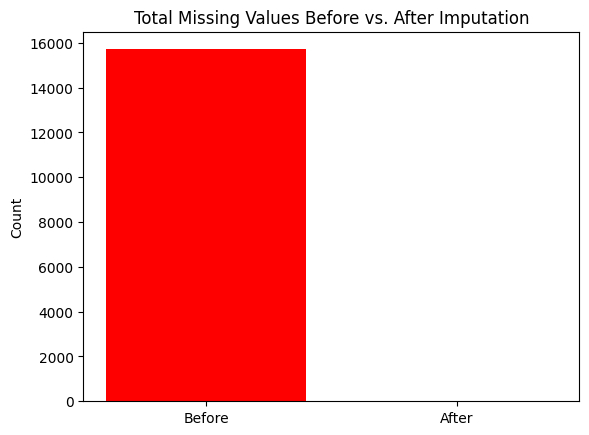

In [7]:
#Number of Missing Features Before vs. After
before_missing = combined.isnull().sum().sum()

# Perform Imputation
combined.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
for col in combined.select_dtypes(include='object'):
    combined[col] = combined[col].fillna('None')
for col in combined.select_dtypes(exclude='object'):
    combined[col] = combined[col].fillna(combined[col].median())

after_missing = combined.isnull().sum().sum()

plt.bar(['Before', 'After'], [before_missing, after_missing], color=['red', 'green'])
plt.title("Total Missing Values Before vs. After Imputation")
plt.ylabel("Count")
plt.show()

** Step 5: Feature Engineering**

In [8]:
#Add Features
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']
combined['TotalBath'] = (combined['FullBath'] + 0.5 * combined['HalfBath'] +
                         combined['BsmtFullBath'] + 0.5 * combined['BsmtHalfBath'])
combined['HouseAge'] = combined['YrSold'] - combined['YearBuilt']
combined['RemodAge'] = combined['YrSold'] - combined['YearRemodAdd']
combined['GarageAge'] = combined['YrSold'] - combined['GarageYrBlt']

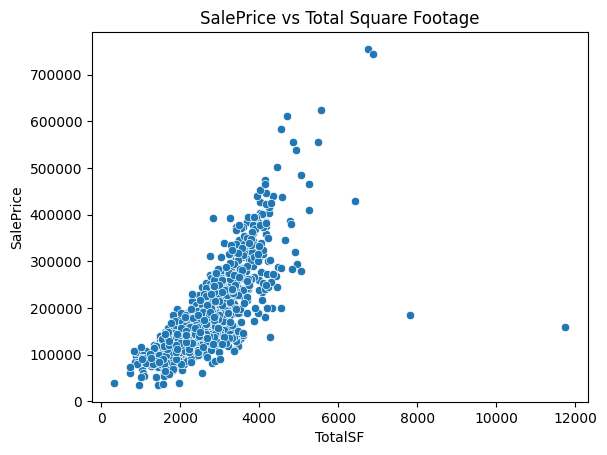

In [9]:
# Only plot training data : SalePrice vs. TotalSF
sns.scatterplot(x=train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF'], y=y)
plt.title("SalePrice vs Total Square Footage")
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")
plt.show()

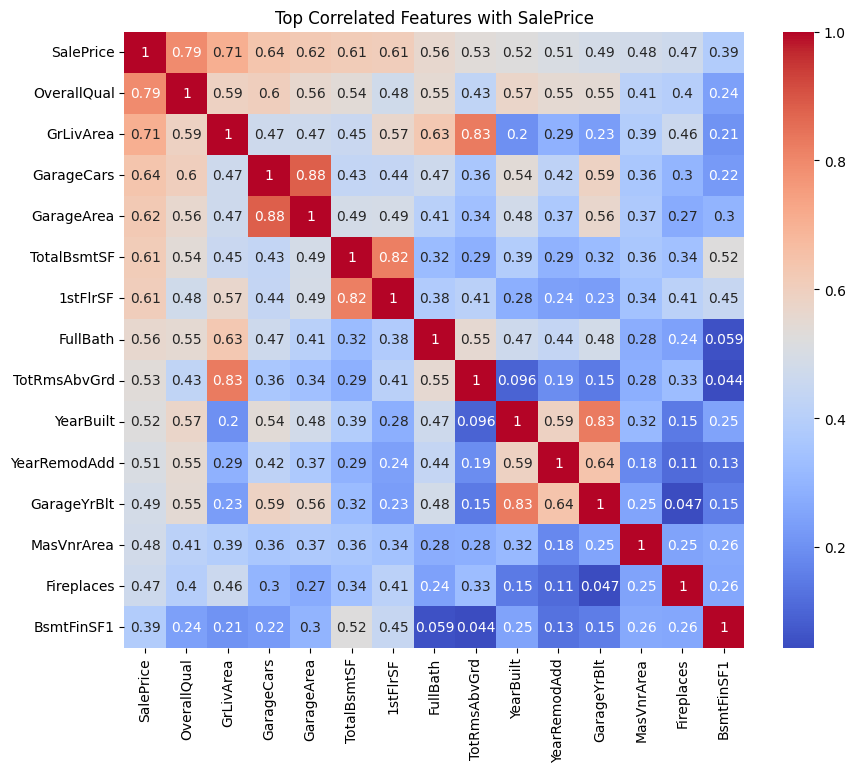

In [10]:
#Correlation Heatmap of Top Features
# Add SalePrice back for correlation
train_numeric = train.copy()
train_numeric['SalePrice'] = y

# Compute correlation
numeric_feats = train_numeric.select_dtypes(include=[np.number])
corr = numeric_feats.corr()
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(15)
top_features = top_corr.index

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_numeric[top_features].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with SalePrice")
plt.show()

**Step 6: Encoding Categorical Features**

In [11]:
from sklearn.preprocessing import LabelEncoder

ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'GarageQual', 'GarageCond']
for col in ordinal_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])

# One-hot encode remaining categoricals
combined = pd.get_dummies(combined)

**Step 7: Train/Test Split**

In [12]:
X = combined[:len(y)]
X_test = combined[len(y):]

**Step 8: Modeling**

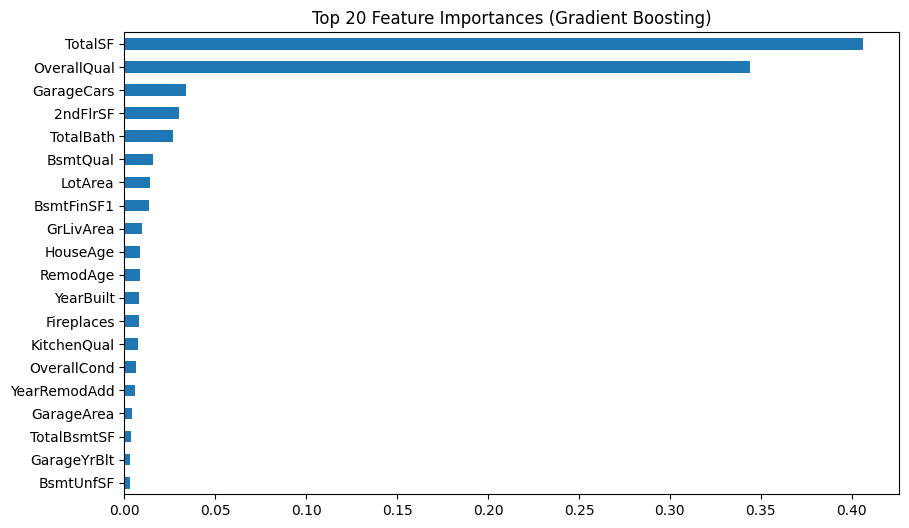

In [13]:
#Visualize Feature Importances
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X, y)

importances = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
importances.plot(kind='barh', title='Top 20 Feature Importances (Gradient Boosting)', figsize=(10,6))
plt.gca().invert_yaxis()
plt.show()

**Step 9: Model Evaluation**

In [14]:
from sklearn.model_selection import cross_val_score

gb_score = cross_val_score(gb, X, y, scoring="neg_root_mean_squared_error", cv=5)
print("Gradient Boosting CV RMSE:", -np.mean(gb_score))

Gradient Boosting CV RMSE: 25428.369328009114


**Step 10: Saving and Visualising Results**

In [15]:
preds = gb.predict(X_test)
output = pd.DataFrame({'Id': test['Id'], 'SalePrice': preds})
output.to_csv('output.csv', index=False)
print(output.head())

     Id      SalePrice
0  1461  123394.412010
1  1462  164357.909717
2  1463  180324.411329
3  1464  182134.536608
4  1465  184920.216208


In [16]:
#Generate CV Predictions
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor

# Initialize model
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Get cross-validated predictions
cv_preds = cross_val_predict(gb, X, y, cv=5)

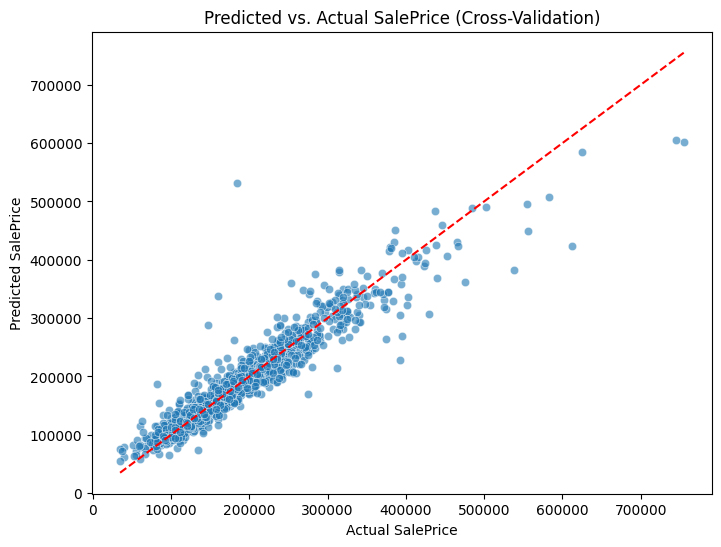

In [17]:
#Visualize Predictions vs. Actual
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=cv_preds, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs. Actual SalePrice (Cross-Validation)")
plt.show()

Summary of Insights

1. **Feature Importance :**

Top predictive features included OverallQual, GrLivArea, GarageCars, TotalSF, KitchenQual, and TotalBath.

Feature engineering improved performance by combining multiple related attributes into more meaningful indicators.

2. **Data Cleaning :**

Columns with excessive missing data such as PoolQC, MiscFeature, and Alley were dropped.

Numerical columns were imputed using the median, while categorical columns were filled with 'None'.

After preprocessing, the dataset contained no missing values, significantly improving model readiness.

**3. Model Evaluation :**

Using 5-fold cross-validation, the Root Mean Squared Error (RMSE) was calculated to evaluate prediction accuracy.

A Predicted vs. Actual scatter plot showed most predictions aligned closely with true sale prices, with minor deviations in outlier regions.

Model interpretability was improved through visualization of feature importances.

**4. Final Prediction :**

The Gradient Boosting model was trained on the full dataset and used to generate predictions for the test set.

The results were saved in a submission.csv file for submission.

